In [1]:
import pandas as pd
import numpy as np
from six.moves import xrange
import math
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle

In [7]:
def cMGRM(theta, alpha=1.5, b=0.5, c=0):
    # MGRM cumulative probability
    return math.e**(alpha*(theta-b+c))/(1+math.e**(alpha*(theta-b+c)))

def model(theta, alpha, b, cl=[1,0,-0.6], start=1):
    sum = start*1
    for c in cl:
        sum += cMGRM(theta, alpha, b, c)
        
    return sum

def partial_derivative_model_alpha(theta, alpha, b, cl):
    # partial derivative of model to alpha
    sum = 0
    for c in cl:
        curr = cMGRM(theta, alpha, b, c)*(1-cMGRM(theta, alpha, b, c))*math.e**(alpha*(theta-b+c))*(theta-b+c)
        sum += curr
        
    return sum

def partial_derivative_model_b(theta, alpha, b, cl):
    # partial derivative of model to b
    sum = 0
    for c in cl:
        curr = cMGRM(theta, alpha, b, c)*(1-cMGRM(theta, alpha, b, c))*math.e**(alpha*(theta-b+c))*(-alpha)
        sum += curr
        
    return sum
        

def partial_derivative_model_theta(theta, alpha, b, cl):
    # partial derivative of model to theta
    sum = 0
    for c in cl:
        curr = cMGRM(theta, alpha, b, c)*(1-cMGRM(theta, alpha, b, c))*math.e**(alpha*(theta-b+c))*(alpha)
        sum += curr
        
    return sum

def partial_derivative_loss(theta, alpha, b, cl, y):
    # partial derivative of loss function to alpha
    # loss = (model(theta)-y))**2
    
    gradient_alpha = 2*(model(theta, alpha, b, cl)-y)*partial_derivative_model_alpha(theta, alpha, b, cl)
    gradient_b = 2*(model(theta, alpha, b, cl)-y)*partial_derivative_model_b(theta, alpha, b, cl)
    gradient_theta = 2*(model(theta, alpha, b, cl)-y)*partial_derivative_model_theta(theta, alpha, b, cl)
    
    return [gradient_alpha, gradient_b, gradient_theta]

def loss(theta, alpha, b, cl, y):
    return (model(theta, alpha, b, cl)-y)**2
    
def calc_gradient_vector(data, parameters):
    # consider the ability of the same person in different training day as different
    uid_p, exc_p = parameters
    cl = [1.359, 1.1, 0.919, 0.782, 0.62, 0.418, 0.388, 0.075, -0.054, -0.056, 
          -0.059, -0.103, -0.156, -0.394, -0.415,
          -0.478, -1.377, -1.471, -1.989]
    
    sum_loss = 0
    
    uid_gradient = pd.DataFrame(np.array([]).reshape(0, 3), columns=['uid', 'day', 'theta_g'])
    exc_gradient = pd.DataFrame(np.array([]).reshape(0, 3), columns=['exc_num', 'alpha_g', 'b_g'])
    
    for day in xrange(5):
        
        day_data = data_day1= data[data['day']==day+1]
        
        groups = day_data.groupby(['exc_num', 'uid'])
        
        for index, group in groups:
            
            exc_num, uid = index
            theta = uid_p.set_index(['uid', 'day']).loc[(uid, day+1)].tolist()[0]
            
            alpha = exc_p.set_index(['exc_num']).loc[exc_num, 'alpha']
            b = exc_p.set_index(['exc_num']).loc[exc_num, 'b']
            y = group['performance'].tolist()[0]
        
            
            gradient_alpha, gradient_b, gradient_theta = partial_derivative_loss(theta, alpha, b, cl, y)
            curr1 = pd.DataFrame(np.array([uid, day+1, gradient_theta]).reshape(1,3), 
                                 columns=['uid', 'day', 'theta_g'])
            curr2 = pd.DataFrame(np.array([exc_num, gradient_alpha, gradient_b]).reshape(1,3), 
                                 columns=['exc_num', 'alpha_g', 'b_g'])
            
            
            uid_gradient = uid_gradient.append(curr1, ignore_index=True)
            exc_gradient = exc_gradient.append(curr2, ignore_index=True)
            
            sum_loss += loss(theta, alpha, b, cl, y)
    print('mean loss is:' + str(sum_loss/len(data)))   
    print(sum_loss)
    return [uid_gradient, exc_gradient]

def update(parameter, gradient, alpha=0.001):
    uid_p, exc_p = parameters
    uid_gradient, exc_gradient = gradient
    
    # calc average theta gradient by each user in each day
    uid_avg = uid_gradient.groupby(['uid', 'day']).mean()    
    # calc average alpha and b by each exercise
    exc_avg = exc_gradient.groupby(['exc_num']).mean()
    
    uid_step = uid_avg*alpha
    exc_step = exc_avg*alpha
    
    uid_result = pd.concat([uid_p.set_index(['uid', 'day']), uid_step], join='inner', axis=1)
    exc_result = pd.concat([exc_p.set_index(['exc_num']), exc_step], join='inner', axis=1)
    
    uid_result['theta'] -= uid_result['theta_g']
    exc_result['alpha'] -= exc_result['alpha_g']
    exc_result['b'] -= exc_result['b_g']
    
    return [uid_result.reset_index()[['uid', 'day', 'theta']], exc_result.reset_index()[['exc_num', 'alpha', 'b']]]
    
    
def initial_parameters(data):
    
    
    uid_p = pd.DataFrame(np.array([]).reshape(0, 3), columns=['uid', 'day', 'theta'])
    exc_p = pd.DataFrame(np.array([]).reshape(0, 3), columns=['exc_num', 'alpha', 'b'])
    
    # compare average score over all exercises of different user
    avg_perf = data[['exc_num', 'uid', 'performance']].groupby(['exc_num', 'uid']).mean()
    count = avg_perf.reset_index()[['exc_num']]
    count['count'] = 0
    count = count[['exc_num', 'count']].groupby(['exc_num']).count()
    excs = count[count['count']== count['count'].max()].reset_index()['exc_num'].unique()
    avg_perf = avg_perf.reset_index().set_index(['exc_num']).loc[excs]
    avg_perf = avg_perf.reset_index().groupby(['exc_num', 'uid']).mean()
    avg_perf = avg_perf.reset_index().groupby(['uid']).mean()
    
    # transform average score in range of [-3, 3]
    max_perf = avg_perf['performance'].max()
    min_perf = avg_perf['performance'].min()
    interval = max_perf-min_perf
    
    avg_perf['theta'] = (avg_perf['performance']-min_perf)/interval*6-3
    
    curr = avg_perf.reset_index()[['uid', 'theta']]
    
    for day in xrange(5):
        day += 1
        curr['day'] = day
        uid_p = pd.concat([uid_p, curr])
        
    
    #################################
    # compare average score over all user of different exercises
    avg_perf = data[['exc_num', 'uid', 'performance']].groupby(['exc_num', 'uid']).mean()
    count = avg_perf.reset_index()[['uid', 'performance']].groupby(['uid']).count()
    uids = count[count['performance']== count['performance'].max()].reset_index()['uid'].unique()
    avg_perf = avg_perf.reset_index().set_index(['uid']).loc[uids]
    avg_perf = avg_perf.reset_index().groupby(['exc_num', 'uid']).mean()
    avg_perf = avg_perf.reset_index().groupby(['exc_num']).mean()
    
    
    # use average score to represent exercise difficulty, and transform them in range of [-2, 2]
    max_perf = avg_perf['performance'].max()
    min_perf = avg_perf['performance'].min()
    interval = max_perf-min_perf
    
    avg_perf['b'] = (avg_perf['performance']-min_perf)/interval*4-2
    avg_perf['b'] = avg_perf['b']*-1
    
    avg_perf = avg_perf.reset_index()
    avg_perf['alpha'] = pd.Series(1.5*np.random.random_sample(len(avg_perf)))
    
    exc_p = avg_perf[['exc_num', 'alpha', 'b']]
    
    
    return uid_p, exc_p
    
    
def select_exc(data, selected_excs=None):
    if selected_excs is None or len(selected_excs)==0:
        return data
    else:
        data = data.set_index(['exc_num'])
        data = data.loc[selected_excs]
        data = data.reset_index()
        return data

In [24]:
expected_performance = pd.read_csv('../data/step2_expected_performance.csv')
expected_performance.head()

,day,exc_num,uid,performance
0,1,1.1,1,6.000000
1,1,1.1,4,5.000000
2,1,1.1,5,7.000000
3,1,1.1,7,6.000000
4,1,1.2,1,5.666667


In [25]:
selected_excs = [1.2, 1.3, 1.4, 2.1, 2.3, 3.2, 4.2, 4.3]
expected_performance = select_exc(expected_performance, selected_excs)
expected_performance

,exc_num,day,uid,performance
0,1.2,1,1,5.666667
1,1.2,1,2,5.500000
2,1.2,1,3,12.000000
3,1.2,1,4,6.000000
4,1.2,1,5,5.500000
5,1.2,1,6,8.200000
6,1.2,1,7,7.500000
7,1.2,1,8,8.000000
8,1.2,1,10,6.000000
9,1.2,2,3,8.000000


In [26]:
try:
    parameters = pickle.load(open('../data/irt_parameters.p', 'rb'))
    
except:
    print('no parameter file')
    parameters = initial_parameters(expected_performance)

for i in xrange(1000):
    gradients = calc_gradient_vector(expected_performance, parameters)
    parameters = update(parameters, gradients)

no parameter file


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:146: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



mean loss is:36.5147913552
5769.33703412
mean loss is:25.7448529832
4067.68677135
mean loss is:21.4542259788
3389.76770465
mean loss is:19.2434587767
3040.46648672
mean loss is:18.1090790354
2861.23448759
mean loss is:17.4762105817
2761.24127191
mean loss is:17.0812914844
2698.84405454
mean loss is:16.8066008158
2655.44292889
mean loss is:16.5956989576
2622.12043529
mean loss is:16.4196702101
2594.30789319
mean loss is:16.2629636897
2569.54826298
mean loss is:16.1169256737
2546.47425645
mean loss is:15.9766424156
2524.30950167
mean loss is:15.8393173029
2502.61213386
mean loss is:15.7033947246
2481.13636649
mean loss is:15.5680621477
2459.75381933
mean loss is:15.4329530889
2438.40658804
mean loss is:15.2979634648
2417.07822743
mean loss is:15.1631361656
2395.77551416
mean loss is:15.0285888291
2374.517035
mean loss is:14.894469723
2353.32621623
mean loss is:14.7609319757
2332.22725216
mean loss is:14.6281196023
2311.24289717
mean loss is:14.4961608874
2290.39342021
mean loss is:14.365

mean loss is:3.35210329715
529.63232095
mean loss is:3.32552244203
525.43254584
mean loss is:3.29925694663
521.282597567
mean loss is:3.27330564003
517.182291124
mean loss is:3.24766731376
513.131435574
mean loss is:3.22234072147
509.129833993
mean loss is:3.19732457856
505.177283412
mean loss is:3.17261756177
501.273574759
mean loss is:3.14821830888
497.418492803
mean loss is:3.12412541832
493.611816094
mean loss is:3.10033744884
489.853316916
mean loss is:3.07685291918
486.142761231
mean loss is:3.05367030783
482.479908636
mean loss is:3.03078805267
478.864512322
mean loss is:3.00820455083
475.296319031
mean loss is:2.98591815843
471.775069032
mean loss is:2.96392719045
468.300496091
mean loss is:2.94222992061
464.872327456
mean loss is:2.9208245813
461.490283845
mean loss is:2.89970936356
458.154079443
mean loss is:2.87888241713
454.863421906
mean loss is:2.85834185051
451.618012381
mean loss is:2.83808573116
448.417545523
mean loss is:2.81811208566
445.261709534
mean loss is:2.7984

mean loss is:1.59971147718
252.754413394
mean loss is:1.59774701277
252.444028018
mean loss is:1.59579552864
252.135693526
mean loss is:1.59385683915
251.829380585
mean loss is:1.59193076244
251.525060466
mean loss is:1.59001712043
251.222705028
mean loss is:1.58811573863
250.922286704
mean loss is:1.58622644611
250.623778485
mean loss is:1.58434907537
250.327153908
mean loss is:1.58248346227
250.032387039
mean loss is:1.58062944595
249.73945246
mean loss is:1.57878686872
249.448325257
mean loss is:1.576955576
249.158981008
mean loss is:1.57513541624
248.871395765
mean loss is:1.57332624082
248.58554605
mean loss is:1.57152790402
248.301408836
mean loss is:1.5697402629
248.018961538
mean loss is:1.56796317724
247.738182004
mean loss is:1.5661965095
247.4590485
mean loss is:1.5644401247
247.181539703
mean loss is:1.56269389043
246.905634688
mean loss is:1.5609576767
246.631312919
mean loss is:1.55923135595
246.35855424
mean loss is:1.55751480294
246.087338865
mean loss is:1.55580789472


mean loss is:1.3405521587
211.807241075
mean loss is:1.33961409167
211.659026484
mean loss is:1.33867776458
211.511086803
mean loss is:1.33774316458
211.363420003
mean loss is:1.33681027899
211.216024081
mean loss is:1.33587909528
211.068897054
mean loss is:1.33494960104
210.922036964
mean loss is:1.33402178401
210.775441874
mean loss is:1.33309563209
210.62910987
mean loss is:1.33217113329
210.48303906
mean loss is:1.33124827578
210.337227573
mean loss is:1.33032704785
210.19167356
mean loss is:1.32940743794
210.046375194
mean loss is:1.32848943461
209.901330669
mean loss is:1.32757302656
209.756538197
mean loss is:1.32665820263
209.611996015
mean loss is:1.32574495176
209.467702378
mean loss is:1.32483326304
209.323655561
mean loss is:1.3239231257
209.17985386
mean loss is:1.32301452906
209.036295591
mean loss is:1.32210746259
208.892979089
mean loss is:1.32120191587
208.749902707
mean loss is:1.32029787861
208.60706482
mean loss is:1.31939534064
208.464463821
mean loss is:1.31849429

mean loss is:1.17658764438
185.900847813
mean loss is:1.1758659447
185.786819262
mean loss is:1.17514503241
185.672915121
mean loss is:1.17442490677
185.559135269
mean loss is:1.17370556703
185.445479591
mean loss is:1.17298701249
185.331947973
mean loss is:1.17226924243
185.218540303
mean loss is:1.17155225615
185.105256472
mean loss is:1.17083605299
184.992096373
mean loss is:1.17012063228
184.879059901
mean loss is:1.16940599337
184.766146953
mean loss is:1.16869213562
184.653357428
mean loss is:1.16797905841
184.540691228
mean loss is:1.16726676112
184.428148257
mean loss is:1.16655524317
184.315728421
mean loss is:1.16584450397
184.203431627
mean loss is:1.16513454294
184.091257785
mean loss is:1.16442535953
183.979206806
mean loss is:1.1637169532
183.867278605
mean loss is:1.1630093234
183.755473097
mean loss is:1.16230246962
183.6437902
mean loss is:1.16159639134
183.532229832
mean loss is:1.16089108808
183.420791916
mean loss is:1.16018655933
183.309476375
mean loss is:1.159482

In [27]:
pickle.dump(parameters, open('../data/irt_parameters.p', 'wb'))

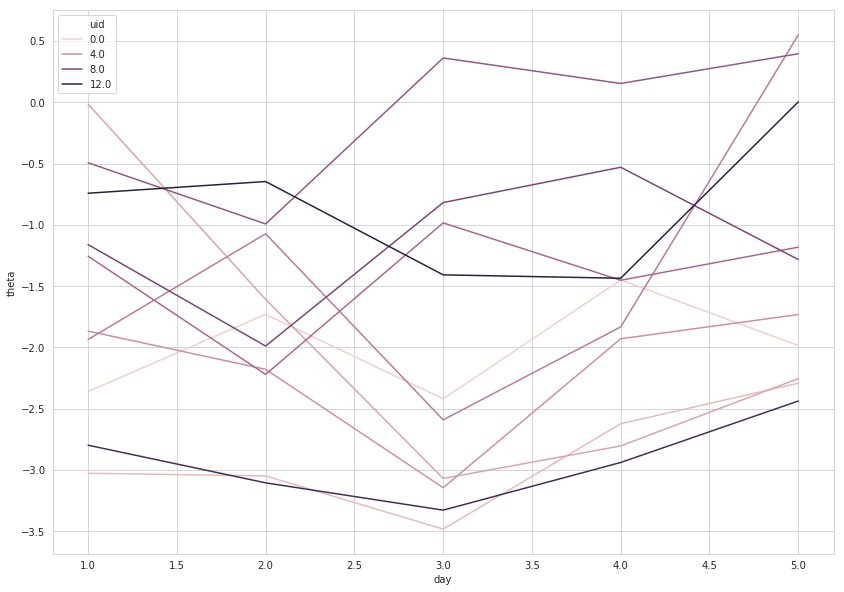

In [28]:
theta_day = parameters[0]
sns.set_style('whitegrid')
f, ax= plt.subplots(figsize = (14, 10))

ax = sns.lineplot(x='day', y='theta', hue='uid', data=theta_day)
#     ax.set_title('exc_num is'+str(index))

In [29]:
parameters

[     uid  day     theta
 0    1.0  1.0 -2.360607
 1    1.0  2.0 -1.730523
 2    1.0  3.0 -2.419064
 3    1.0  4.0 -1.449785
 4    1.0  5.0 -1.984354
 5    2.0  1.0 -3.027097
 6    2.0  2.0 -3.048939
 7    2.0  3.0 -3.482569
 8    2.0  4.0 -2.622988
 9    2.0  5.0 -2.292167
 10   3.0  1.0 -0.014991
 11   3.0  2.0 -1.608514
 12   3.0  3.0 -3.069360
 13   3.0  4.0 -2.804038
 14   3.0  5.0 -2.255551
 15   4.0  1.0 -1.867143
 16   4.0  2.0 -2.179084
 17   4.0  3.0 -3.145173
 18   4.0  4.0 -1.929788
 19   4.0  5.0 -1.732109
 20   5.0  1.0 -1.935653
 21   5.0  2.0 -1.073214
 22   5.0  3.0 -2.591415
 23   5.0  4.0 -1.832885
 24   5.0  5.0  0.549313
 25   6.0  1.0 -1.256236
 26   6.0  2.0 -2.220810
 27   6.0  3.0 -0.984161
 28   6.0  4.0 -1.452534
 29   6.0  5.0 -1.182589
 30   7.0  1.0 -0.493975
 31   7.0  2.0 -0.992916
 32   7.0  3.0  0.361128
 33   7.0  4.0  0.153144
 34   7.0  5.0  0.395693
 35   8.0  1.0 -1.161442
 36   8.0  2.0 -1.989007
 37   8.0  3.0 -0.818530
 38   8.0  4.0 -0.530510
